# Przygotowanie

In [104]:
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gensim
import logging
from collections import defaultdict 

Na początku zdefiniujmy sobie kilka zmiennych globalnych takich jak:
- DATASET_PATH - ścieżkę do pliku z tweetami
- W2V_MODEL_PATH - gdzie ma zostać zapisany model w2v

- DATASET_COLUMNS - nazwy kolumn
- DATASET_ENCODING - typ kodowaniu wykorzystany w naszym datasecie

In [110]:
from const import DATASET_PATH, W2V_MODEL_PATH, PREPROCESSED_TEST_PATH, PREPROCESSED_TRAIN_PATH
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

ImportError: cannot import name 'PREPROCESSED_TEST_PATH' from 'const' (/Users/lukasz/studies/psi-project/const.py)

# Wczytanie danych

Możemy teraz wczytać nasz dataset. Jako, że tweety znajdują się w pliku `csv` możemy do tego użyć wbudowanej funkcji z bilbioteki `pandas`.

In [3]:
df = pd.read_csv(os.path.abspath(DATASET_PATH), encoding = DATASET_ENCODING , names = DATASET_COLUMNS)

Łatwo możemy sprawdzić z ilą danymi mamy tak naprawdę doczynienia:

In [4]:
df.shape

(1600000, 6)

Widmimy, że nasz zbiór danych składa się z 1600000 wierszy po 6 kolumn.

Wyświetlmy sobie teraz pierwsze 10 wierszy naszego setu:

In [5]:
df.head(10)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


Od razu widzimy, że niektóre z kolumn nam się nie przydadzą w dalszej analizie. Więc możemy spokojnie je usnąć.

In [6]:
df = df.drop(columns=["ids", "date", "flag", "user"])

Zostawiliśmy tylko dwie kolumny: `target` oraz `test`. Pierwsza z nich odpowiada emocją jakie niesie za sobą dany tweet. `0` oznacza negatywną wiadomość natomiast `4` odpowiada wiadomości pozytywnej. Teoreytcznie wartość `2` oznaczała by widomość neutralną. Jednak jak łatwo sprawdzić taka wartość nie występuje w tym zbiorze. 

In [7]:
df.target.unique()

array([0, 4])

# Czyszczenie treści tweetów

Musimy oczyścić treść posów z:
- linków 
- nazw użytkowników
- znaków specjalnych
- hashtagów

W tym celu posłużymy się wyrażeniami regularnymi.

In [8]:
def get_clean_regex():
    users = "@\S+" # usuwa dowolne, niebiałe znaki po @ 
    links = "((www\.[^\s]+)|(https?://[^\s]+))" # usuwa linki
    not_alpha_numeric = "[^A-Za-z0-9]"
    hashtags = "#\S+" # usuwa dowolne, niebiałe znaki po #
    return "|".join([users, links, not_alpha_numeric, hashtags])
    

In [9]:
clean_regex = get_clean_regex()
print(clean_regex)

@\S+|((www\.[^\s]+)|(https?://[^\s]+))|[^A-Za-z0-9]|#\S+


In [10]:
df.text = df.text.apply(lambda x: re.sub(clean_regex, ' ', str(x).lower()).strip())

In [11]:
df.head(5).text

0    awww  that s a bummer   you shoulda got david ...
1    is upset that he can t update his facebook by ...
2    i dived many times for the ball  managed to sa...
3       my whole body feels itchy and like its on fire
4    no  it s not behaving at all  i m mad  why am ...
Name: text, dtype: object

In [12]:
df.text[0]

'awww  that s a bummer   you shoulda got david carr of third day to do it   d'

Całościowo wygląda dobrze, oprócz tego, że w tekscie teraz może występować wiele białych znaków obok siebie.

Dlatego, też musimy jeszcze wykonać jedną transformację na naszym zbiorze:

In [13]:
df.text = df.text.apply(lambda x: re.sub("\s+", ' ', str(x)).strip())

In [14]:
df.head(5).text

0    awww that s a bummer you shoulda got david car...
1    is upset that he can t update his facebook by ...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no it s not behaving at all i m mad why am i h...
Name: text, dtype: object

In [15]:
df.text[0]

'awww that s a bummer you shoulda got david carr of third day to do it d'

Warto jeszcze usunąc tak zwane **stop words** czyli słowa, których używamy ze względu na zasady gramatyczne i zwykle nie dodają znaczenia. Na przykład, są nimi: "the", "a", "an", "in. 

Moglibyśmy sami stworzyć słownik takich zwrotów. Jednak nie jest to wymagane, poniważ możemy skorzystać z gotowego rozwiązania.

In [16]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lukasz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def remove_stop_words(text, stop_words):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

df.text = df.text.apply(lambda x: remove_stop_words(str(x), stop_words).strip())

In [18]:
df.head(5).text

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save 50 rest go ...
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

In [19]:
df.head(5).text[0]

'awww bummer shoulda got david carr third day'

Możemy teraz zająć się labelami. Tu sprawda będzie prostsza. Musimy jednynie zamienić `4` na `1`.  

In [20]:
df.target = df.target.replace(4,1)

In [21]:
df.head

<bound method NDFrame.head of          target                                               text
0             0       awww bummer shoulda got david carr third day
1             0  upset update facebook texting might cry result...
2             0  dived many times ball managed save 50 rest go ...
3             0                   whole body feels itchy like fire
4             0                                   behaving mad see
...         ...                                                ...
1599995       1                      woke school best feeling ever
1599996       1           thewdb com cool hear old walt interviews
1599997       1                    ready mojo makeover ask details
1599998       1  happy 38th birthday boo alll time tupac amaru ...
1599999       1                               happy charitytuesday

[1600000 rows x 2 columns]>

# Charakterystyka danych

Dokonaliśmy już wstępnej obróbki danych. Jednak nie wiemy jeszcze jak wygląda rozkład labeli w naszym datasecie. 

In [22]:
df.target.value_counts()

1    800000
0    800000
Name: target, dtype: int64

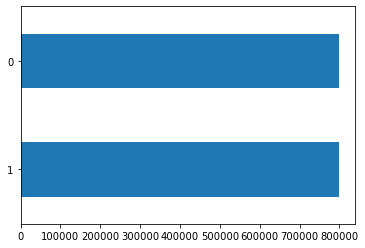

In [23]:
df.target.value_counts().sort_values().plot(kind = 'barh')

Już wiemy, że rozkład mamy tyle samo wiadomości pozytywnych co tych negatywnych.

Możemy jednocześnie policzyć jakie słowa występują najczęściej (oczywiście po wstępnym czyczeniu)

In [60]:
def count_word_freq(document):
    count = defaultdict(int)
    for sentence in document:
        for s in sentence:
            count[s] += 1
    return count
count_word_freq = count_word_freq(documents)

In [82]:
word_freq_count_df = pd.DataFrame.from_dict(count_word_freq, orient='index', columns=["count"])
best_word_freq = word_freq_count_df.sort_values(by="count", ascending=False)[:10]
print(best_word_freq)

       count
good   73143
day    69619
get    65710
like   62917
go     59220
quot   57523
today  54538
work   51806
love   51690
going  51557


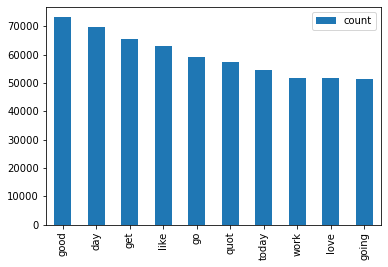

In [83]:
best_word_freq.plot(kind = 'bar')

# Podział na train i test

In [24]:
df_train, df_test = train_test_split(df, test_size = 0.2)
print("Podział danych")
print("  > Train: ", len(df_train))
print("  > Test: ", len(df_test))

Podział danych
  > Train:  1280000
  > Test:  320000


# Word2Vec
Następnym krokiem, który musismy wykonać jest zamiana słów na wektory. W tym celu posłużym się model zaimplementowanym w biliotece `gensim`. Model ten wykorzystuje prostą sieć neuronową.

Aby nasze dane były kompatybilne z tym algorytmem musimy zamienić je na listę list (każde znadnie jest zamienione na osobną listę).

In [25]:
documents = [_text.split() for _text in df_train.text] 

W celu monitorowania postępów dodamy loggera.

In [50]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)

Tworzymy teraz model podając kilka parametrów:
- __min_count__ - ignoruje słowa o mniejszej liczebności niż zadana
- __size__ - rozmar wyjściowych wektorów
- __window__ - maksymalny dystans pomiędzy słowami
- __alpha__ - learning rate
- __min_aplha__ - minimalna wartość learning ratu

In [51]:
w2v_model = gensim.models.word2vec.Word2Vec(min_count = 10,
                                            window = 7,
                                            size = 300,
                                            alpha = 0.03, 
                                            min_alpha = 0.0007, 
                                            workers = 7)

In [52]:
w2v_model.build_vocab(documents)

2020-06-05 13:50:07,193 : INFO : collecting all words and their counts
2020-06-05 13:50:07,194 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-05 13:50:07,211 : INFO : PROGRESS: at sentence #10000, processed 71630 words, keeping 13450 word types
2020-06-05 13:50:07,229 : INFO : PROGRESS: at sentence #20000, processed 143025 words, keeping 20651 word types
2020-06-05 13:50:07,248 : INFO : PROGRESS: at sentence #30000, processed 214649 words, keeping 26205 word types
2020-06-05 13:50:07,266 : INFO : PROGRESS: at sentence #40000, processed 286003 words, keeping 31012 word types
2020-06-05 13:50:07,283 : INFO : PROGRESS: at sentence #50000, processed 357234 words, keeping 35411 word types
2020-06-05 13:50:07,299 : INFO : PROGRESS: at sentence #60000, processed 429041 words, keeping 39391 word types
2020-06-05 13:50:07,316 : INFO : PROGRESS: at sentence #70000, processed 500926 words, keeping 43090 word types
2020-06-05 13:50:07,335 : INFO : PROGRESS: at s

2020-06-05 13:50:08,449 : INFO : PROGRESS: at sentence #720000, processed 5141601 words, keeping 172573 word types
2020-06-05 13:50:08,466 : INFO : PROGRESS: at sentence #730000, processed 5212523 words, keeping 173993 word types
2020-06-05 13:50:08,490 : INFO : PROGRESS: at sentence #740000, processed 5283772 words, keeping 175383 word types
2020-06-05 13:50:08,508 : INFO : PROGRESS: at sentence #750000, processed 5356209 words, keeping 176819 word types
2020-06-05 13:50:08,526 : INFO : PROGRESS: at sentence #760000, processed 5427493 words, keeping 178206 word types
2020-06-05 13:50:08,544 : INFO : PROGRESS: at sentence #770000, processed 5498778 words, keeping 179613 word types
2020-06-05 13:50:08,561 : INFO : PROGRESS: at sentence #780000, processed 5569334 words, keeping 180986 word types
2020-06-05 13:50:08,579 : INFO : PROGRESS: at sentence #790000, processed 5640375 words, keeping 182391 word types
2020-06-05 13:50:08,597 : INFO : PROGRESS: at sentence #800000, processed 571108

Możemy teraz wytrenować nasz model.

In [54]:
w2v_model.train(documents, total_examples=w2v_model.corpus_count, epochs=30)

2020-06-05 13:51:41,288 : INFO : training model with 7 workers on 30067 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-06-05 13:51:42,302 : INFO : EPOCH 1 - PROGRESS: at 19.48% examples, 1591574 words/s, in_qsize 12, out_qsize 1
2020-06-05 13:51:43,305 : INFO : EPOCH 1 - PROGRESS: at 39.47% examples, 1613146 words/s, in_qsize 12, out_qsize 1
2020-06-05 13:51:44,310 : INFO : EPOCH 1 - PROGRESS: at 60.04% examples, 1634635 words/s, in_qsize 13, out_qsize 0
2020-06-05 13:51:45,310 : INFO : EPOCH 1 - PROGRESS: at 80.07% examples, 1635601 words/s, in_qsize 13, out_qsize 0
2020-06-05 13:51:46,295 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-05 13:51:46,300 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-05 13:51:46,301 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-05 13:51:46,306 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-05 13:51:46,310 : 

2020-06-05 13:52:15,627 : INFO : EPOCH 7 - PROGRESS: at 55.67% examples, 1511012 words/s, in_qsize 14, out_qsize 1
2020-06-05 13:52:16,631 : INFO : EPOCH 7 - PROGRESS: at 72.87% examples, 1483576 words/s, in_qsize 13, out_qsize 2
2020-06-05 13:52:17,632 : INFO : EPOCH 7 - PROGRESS: at 91.86% examples, 1498396 words/s, in_qsize 13, out_qsize 0
2020-06-05 13:52:18,071 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-05 13:52:18,075 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-05 13:52:18,076 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-05 13:52:18,081 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-05 13:52:18,086 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-05 13:52:18,087 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-05 13:52:18,094 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-05 13:52:1

2020-06-05 13:52:49,517 : INFO : EPOCH 13 - PROGRESS: at 77.34% examples, 1574212 words/s, in_qsize 12, out_qsize 1
2020-06-05 13:52:50,520 : INFO : EPOCH 13 - PROGRESS: at 96.56% examples, 1573923 words/s, in_qsize 12, out_qsize 1
2020-06-05 13:52:50,663 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-05 13:52:50,669 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-05 13:52:50,671 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-05 13:52:50,677 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-05 13:52:50,677 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-05 13:52:50,686 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-05 13:52:50,687 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-05 13:52:50,688 : INFO : EPOCH - 13 : training on 9140124 raw words (8193044 effective words) took 5.2s, 1577316 effective 

2020-06-05 13:53:24,368 : INFO : EPOCH 19 - PROGRESS: at 81.16% examples, 1318992 words/s, in_qsize 12, out_qsize 1
2020-06-05 13:53:25,368 : INFO : EPOCH 19 - PROGRESS: at 97.21% examples, 1318632 words/s, in_qsize 13, out_qsize 0
2020-06-05 13:53:25,483 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-05 13:53:25,489 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-05 13:53:25,490 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-05 13:53:25,495 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-05 13:53:25,499 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-05 13:53:25,500 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-05 13:53:25,505 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-05 13:53:25,506 : INFO : EPOCH - 19 : training on 9140124 raw words (8192496 effective words) took 6.2s, 1326033 effective 

2020-06-05 13:53:59,933 : INFO : EPOCH 25 - PROGRESS: at 86.08% examples, 1402062 words/s, in_qsize 12, out_qsize 1
2020-06-05 13:54:00,635 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-05 13:54:00,639 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-05 13:54:00,646 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-05 13:54:00,647 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-05 13:54:00,648 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-05 13:54:00,657 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-05 13:54:00,658 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-05 13:54:00,659 : INFO : EPOCH - 25 : training on 9140124 raw words (8192780 effective words) took 5.8s, 1423570 effective words/s
2020-06-05 13:54:01,672 : INFO : EPOCH 26 - PROGRESS: at 19.15% examples, 1563680 words/s, in_qsize 13, out_

(245788241, 274203720)

Aby zweryfikować jego działanie możemy wypisać podobne znaczeniowo słowa do danego wyrazu. Jeśli faktycznie będę podobne oznacza to, że mają one podobną reprezentację wektorową w naszym modelu - co chcieliśmy osiągnąć.

In [55]:
w2v_model.most_similar("dog")

/opt/anaconda3/envs/sentimental140/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-06-05 13:54:35,760 : INFO : precomputing L2-norms of word weight vectors


[('puppy', 0.6332559585571289),
 ('cat', 0.6248475313186646),
 ('dogs', 0.6020611524581909),
 ('pup', 0.5633569955825806),
 ('doggy', 0.5555011630058289),
 ('doggie', 0.5480417013168335),
 ('kitten', 0.5437886118888855),
 ('kitty', 0.5385284423828125),
 ('yorkie', 0.494467556476593),
 ('beagle', 0.49058279395103455)]

In [56]:
w2v_model.most_similar("cat")

/opt/anaconda3/envs/sentimental140/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('dog', 0.6248475909233093),
 ('kitten', 0.5832688808441162),
 ('kitty', 0.5827884674072266),
 ('cats', 0.5259411334991455),
 ('kittens', 0.48069098591804504),
 ('puppy', 0.47000187635421753),
 ('stray', 0.45526397228240967),
 ('pug', 0.43060335516929626),
 ('meowing', 0.4295699894428253),
 ('litter', 0.42768192291259766)]

# Zapisywanie

Odpowiedź dawane przez nasz model wyglądają dobrze. Dlatego też możemy zoptymalizować i zapisać nasz model.

In [88]:
w2v_model.init_sims(replace = True)
w2v_model.save(W2V_MODEL_PATH)

2020-06-05 14:12:20,772 : INFO : precomputing L2-norms of word weight vectors
2020-06-05 14:12:20,808 : INFO : saving Word2Vec object under W2V.model, separately None
2020-06-05 14:12:20,809 : INFO : not storing attribute vectors_norm
2020-06-05 14:12:20,810 : INFO : not storing attribute cum_table
2020-06-05 14:12:21,359 : INFO : saved W2V.model


Zapiszmy jednocześnie nasz model w formie `pickla`.

In [109]:
df_train.to_pickle(PREPROCESSED_TRAIN_PATH)
df_test.to_pickle(PREPROCESSED_TEST_PATH)